## ECE495 Intro to programming neurons with Nengo: Dynamics

In this demonstration we will:

1. Understand and implement recurrence in a Nengo network
2. Create an integrator with neurons
3. Create an oscillator with neurons

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [34]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal

### Recurrence in Nengo

Recurrence in neural networks can be used to implement stable dynamics. Such dynamics are important for memory, noise cleanup, statistical inference, and many other dynamic transformations. Recurrent neurons can also be used if you will be performing the same computation over and over again within an algorithm (i.e. just build the neuron once and send in different inputs). Another use of recurrent neurons is online learning (edge computing), depending on the algorithm.


In [ ]:
model = nengo.Network(label="Recurrence")

synaptic_tau = .005 # actual neuron tau, much smaller, responds quickly but noisily
desired_tau = .05 # much larger, therefore more stable for network as a whole

with model:
    a = nengo.Ensemble(100, dimensions=1)

    stim = nengo.Node(Piecewise({0: 0, 1: 1}))
    nengo.Connection(stim, a)

    b = nengo.Ensemble(100, dimensions=1)

    def forward(u):
        return (synaptic_tau/desired_tau)*u
    
    nengo.Connection(a, b, function = forward, synapse=synaptic_tau)

    


### Integrator

This is a simple example of a recurrent network (there are several other tutorials [here](https://www.nengo.ai/nengo/examples.html#building-dynamical-systems)). 

The input is a piecewise function so you can see that the output is integrating (i.e. summing over time) the input. Note that since the integrator constantly sums its input, it will saturate quickly if you leave the input non-zero. This makes it clear that neurons have a finite range of representation. Such saturation effects however can be exploited to perform useful computations (e.g. soft normalization).

This model specifically demonstrates recurrence using one recurrently connected ensemble and an input population. This is also referred to as an _integrator_ becaues it's integrating (summing) inputs over time.

In [31]:
model = nengo.Network(label="Integrator")
with model:
    # create the recurrent neuron ensemble
    A = nengo.Ensemble(100, dimensions=1)

    # create piecewise input
    input = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 2: -2, 3: 0, 4: 1, 5: 0}))

    # Connect the population to itself
    # Using a long time constant for stability (less noise)
    tau = 0.1 
    nengo.Connection(A, A, transform=[[1]], synapse=tau)  
    
    # Connect the input
    # The same time constant as recurrent to make it more 'ideal'
    nengo.Connection(input, A, transform=[[tau]], synapse=tau)  

#### Probe it and Run it

In [32]:
with model:
    # Add probes
    input_probe = nengo.Probe(input)
    A_probe = nengo.Probe(A, synapse=0.01)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 6 seconds
    sim.run(6)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:02.                                                 


#### Plot it

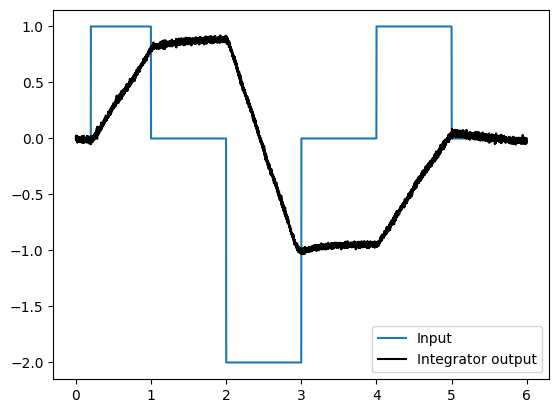

In [33]:
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], label="Input")
plt.plot(sim.trange(), sim.data[A_probe], "k", label="Integrator output")
plt.legend()

#### Discussion

The graph shows the response to the input by the integrator. Because it is implemented in neurons, it will not be perfect (i.e. there will be drift). Running several times will give a sense of the kinds of drift you might expect. Drift can be reduced by increasing the number of neurons.